# Импорты

In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

## Анализ целевой переменной

In [ ]:
def load_data(data_dir='data'):
    train = pd.read_csv(os.path.join(data_dir, 'train.csv'), dtype={'StateHoliday': str})
    test = pd.read_csv(os.path.join(data_dir, 'test.csv'), dtype={'StateHoliday': str})
    store = pd.read_csv(os.path.join(data_dir, 'store.csv'))
    
    train['Date'] = pd.to_datetime(train['Date'])
    test['Date'] = pd.to_datetime(test['Date'])
    
    return train, test, store

def merge_data(train, test, store):
    train_merged = pd.merge(train, store, on='Store', how='left')
    test_merged = pd.merge(test, store, on='Store', how='left')
    
    return train_merged, test_merged

def process_date(df, date_col='Date'):
    df = df.copy()
    df['Year'] = df[date_col].dt.year
    df['Month'] = df[date_col].dt.month
    df['Day'] = df[date_col].dt.day
    df['DayOfWeek'] = df[date_col].dt.dayofweek + 1
    df['WeekOfYear'] = df[date_col].dt.isocalendar().week.astype(int)
    
    return df

train, test, store = load_data('data')
train_merged, test_merged = merge_data(train, test, store)
train_merged = process_date(train_merged)

print("Train shape:", train_merged.shape)
train_merged.head()

Train shape: (1017209, 22)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31


In [38]:
store.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

### Распределение таргета и поиск аномальных значений

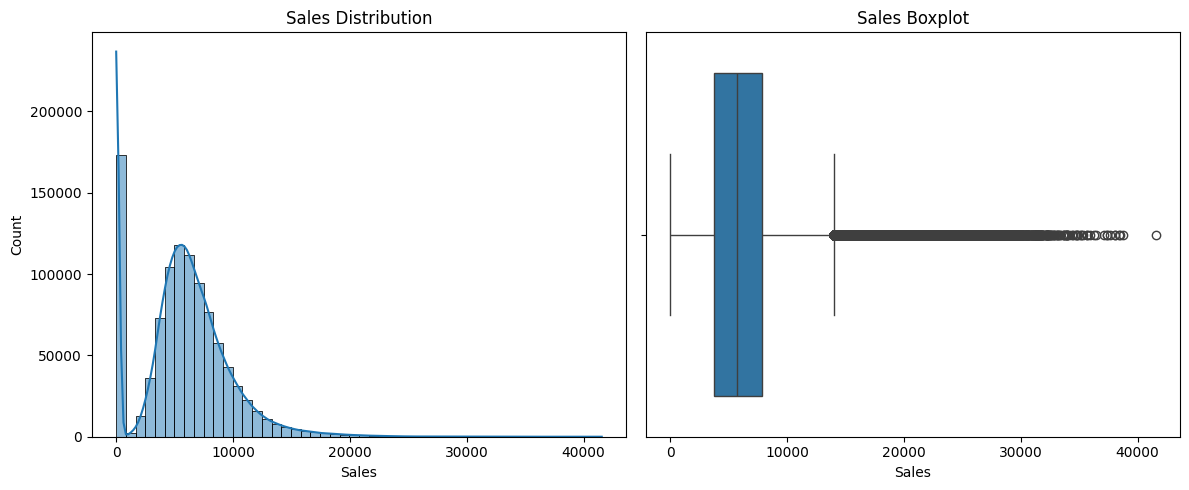

In [6]:
def plot_target_distribution(df, target_col):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(df[target_col], kde=True, bins=50)
    plt.title(f'{target_col} Distribution')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[target_col])
    plt.title(f'{target_col} Boxplot')
    
    plt.tight_layout()
    plt.show()

plot_target_distribution(train_merged, 'Sales')

Видно много нулевых значение в sales. Скорее всего - связано с тем что магазины в часть дней были преимущественно закрыты \
Также вижно много выбросов в sales. Попробуем изучить их подробнее

In [ ]:
def analyze_target_anomalies(df, target_col):
    stats = df[target_col].describe()
    print(f"\nСтатистики {target_col}:")
    print(stats)
    
    Q1, Q3 = df[target_col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    
    outliers = df[(df[target_col] < lower) | (df[target_col] > upper)]
    print(f"\nАномалий по IQR: {len(outliers)} ({100*len(outliers)/len(df):.2f}%)")
    print(f"Диапазон нормы: [{lower:.0f}, {upper:.0f}]")
    
    zeros = (df[target_col] == 0).sum()
    print(f"Нулевых значений: {zeros} ({100*zeros/len(df):.2f}%)")

analyze_target_anomalies(train_merged, 'Sales')


Статистики Sales:
count    1.017209e+06
mean     5.773819e+03
std      3.849926e+03
min      0.000000e+00
25%      3.727000e+03
50%      5.744000e+03
75%      7.856000e+03
max      4.155100e+04
Name: Sales, dtype: float64

Аномалий по IQR: 26694 (2.62%)
Диапазон нормы: [-2466, 14050]
Нулевых значений: 172871 (16.99%)


После фильтрации Open==1 & Sales>0 останется правосторонняя асимметрия с длинным хвостом выбросов до 41к.

Boxplot подтверждает много экстремумов справа (праздники, крупные магазины) при нормальной медиане 5700. Думаю, лучше обучать только на открытых магазинах и применить log-трансформацию таргета для стабилизации дисперсии и улучшения работы модели.

,Metric,Anomaly (n=26690),Normal (n=990519),Diff
Feature,,,,
Promo,Mean,0.7187,0.3724,0.3463
Open,Mean,1.0000,0.8255,0.1745
SchoolHoliday,Mean,0.2265,0.1774,0.0491
Customers,Mean,1987.1337,596.6621,1390.4716
CompetitionDistance,Mean,3572.0082,5480.2477,-1908.2394
StoreType,Mode,a,a,True


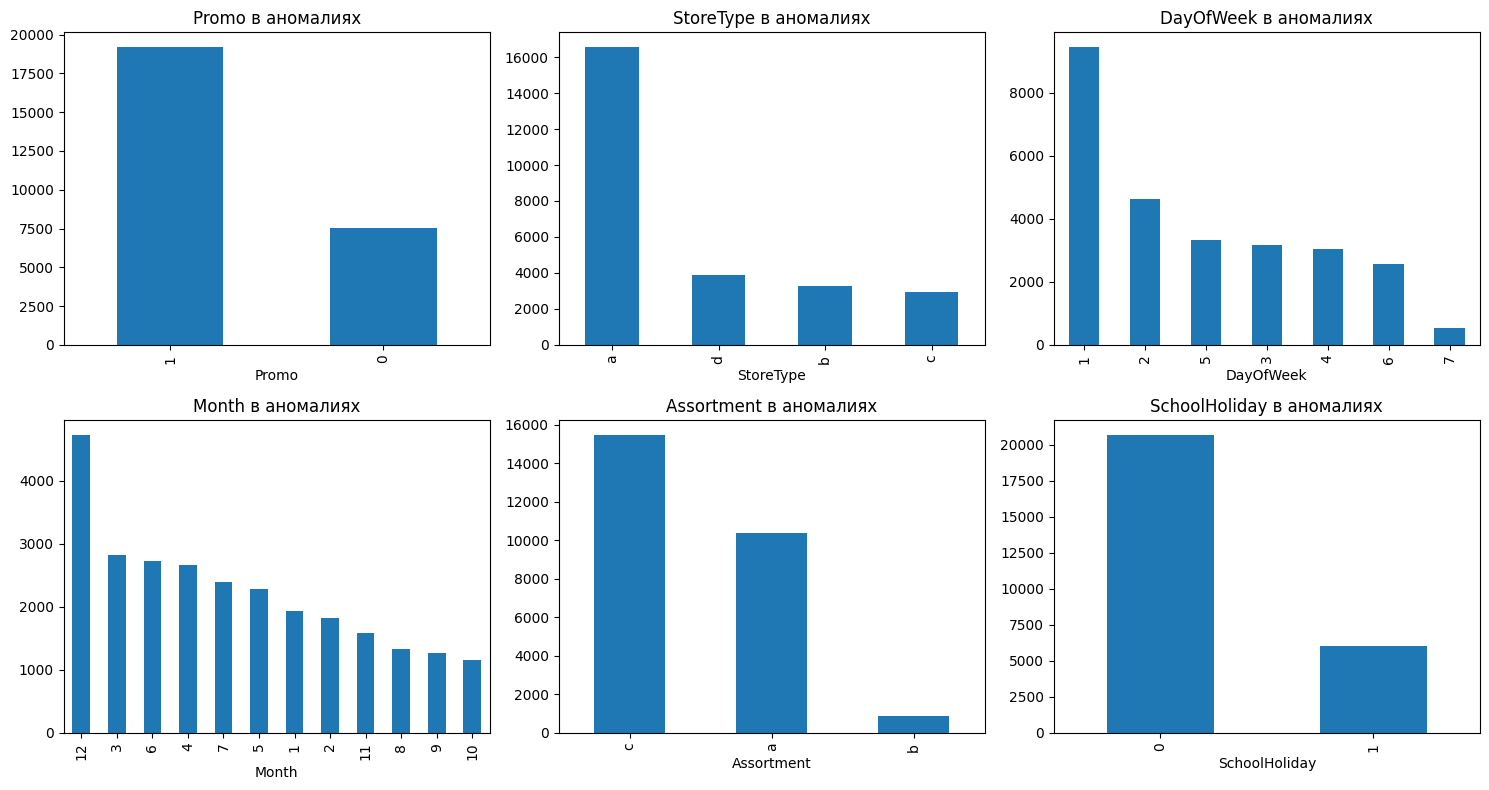

In [ ]:
outliers = train_merged[train_merged['Sales'] > 14050]
normal = train_merged[train_merged['Sales'] <= 14050]

def compare_segments(df, mask, mask_name='Anomaly', rest_name='Normal', features=None):
    """
    Сравнивает средние (для чисел) или моду (для категорий) в двух сегментах.
    """
    if features is None:
        features = df.columns
        
    res = []
    
    segment_1 = df[mask]
    segment_2 = df[~mask]
    
    for col in features:
        if pd.api.types.is_numeric_dtype(df[col]):
            val1 = segment_1[col].mean()
            val2 = segment_2[col].mean()
            metric = 'Mean'
        else:
            val1 = segment_1[col].mode()[0]
            val2 = segment_2[col].mode()[0]
            metric = 'Mode'
            
        res.append({
            'Feature': col,
            'Metric': metric,
            f'{mask_name} (n={len(segment_1)})': val1,
            f'{rest_name} (n={len(segment_2)})': val2,
            'Diff': val1 - val2 if metric == 'Mean' else (val1 == val2)
        })
        
    return pd.DataFrame(res).set_index('Feature')

mask_outliers = train_merged['Sales'] > 14050
features_to_check = ['Promo', 'Open', 'SchoolHoliday', 'Customers', 'CompetitionDistance', 'StoreType']
comparison_df = compare_segments(train_merged, mask_outliers, features=features_to_check)
display(comparison_df)

# Визуализация
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for idx, col in enumerate(['Promo', 'StoreType', 'DayOfWeek', 'Month', 'Assortment', 'SchoolHoliday']):
    outliers[col].value_counts().plot(kind='bar', ax=axes[idx//3, idx%3], title=f'{col} в аномалиях')
plt.tight_layout()
plt.show()

Аномалии - просто комбо из акций Promo (72% против обычных 37%), понедельников и декабря. Людей в такие дни в 3 раза больше обычного 2000 против 600. Все аномалии только когда магазин открыт, что логично, а ещё там чаще полный ассортимент c вместо базового a.

Promo2 работает наоборот. В аномалиях его меньше (27% против 51%), потому что, видимо, эти долгие акции вешают на слабые магазы. Ещё аномалии чаще когда конкурент ближе (3.5км против 5.5км). SchoolHoliday влияет слабо (23% vs 18%). В общем главное - Promo + понедельник/декабрь + куча людей + широкий ассортимент, вот тебе и выброс в 40к продаж.

### Визуализация статистик

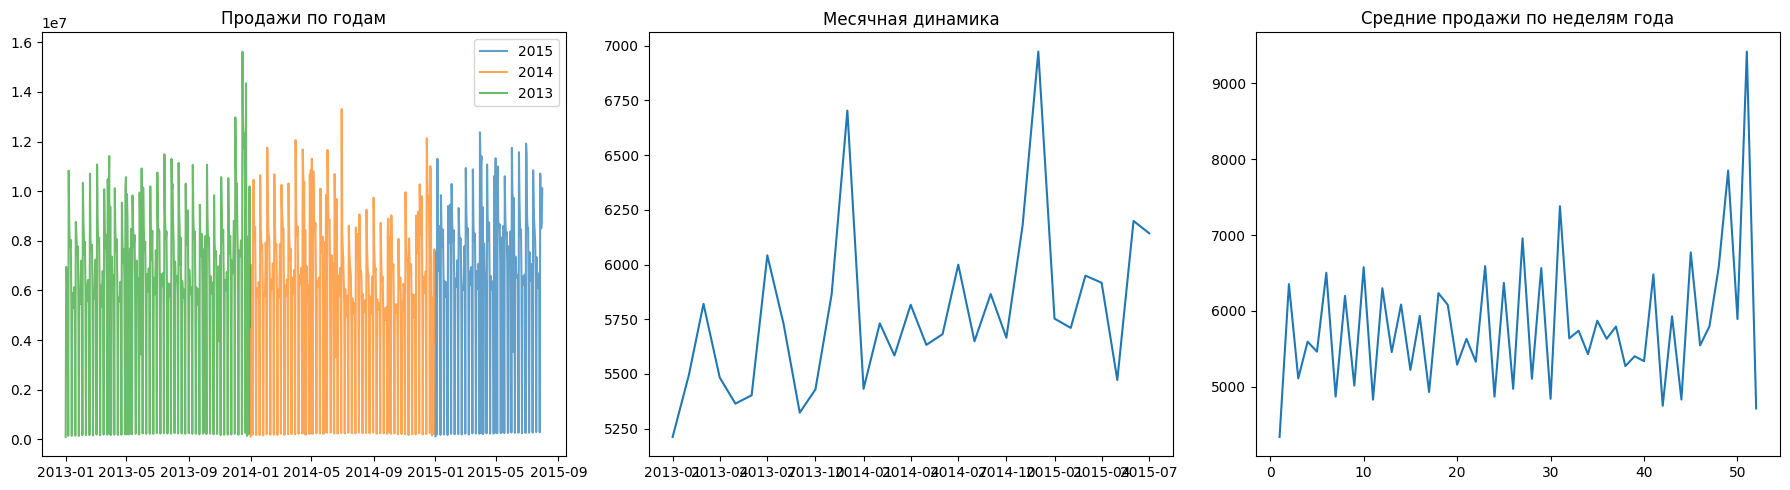

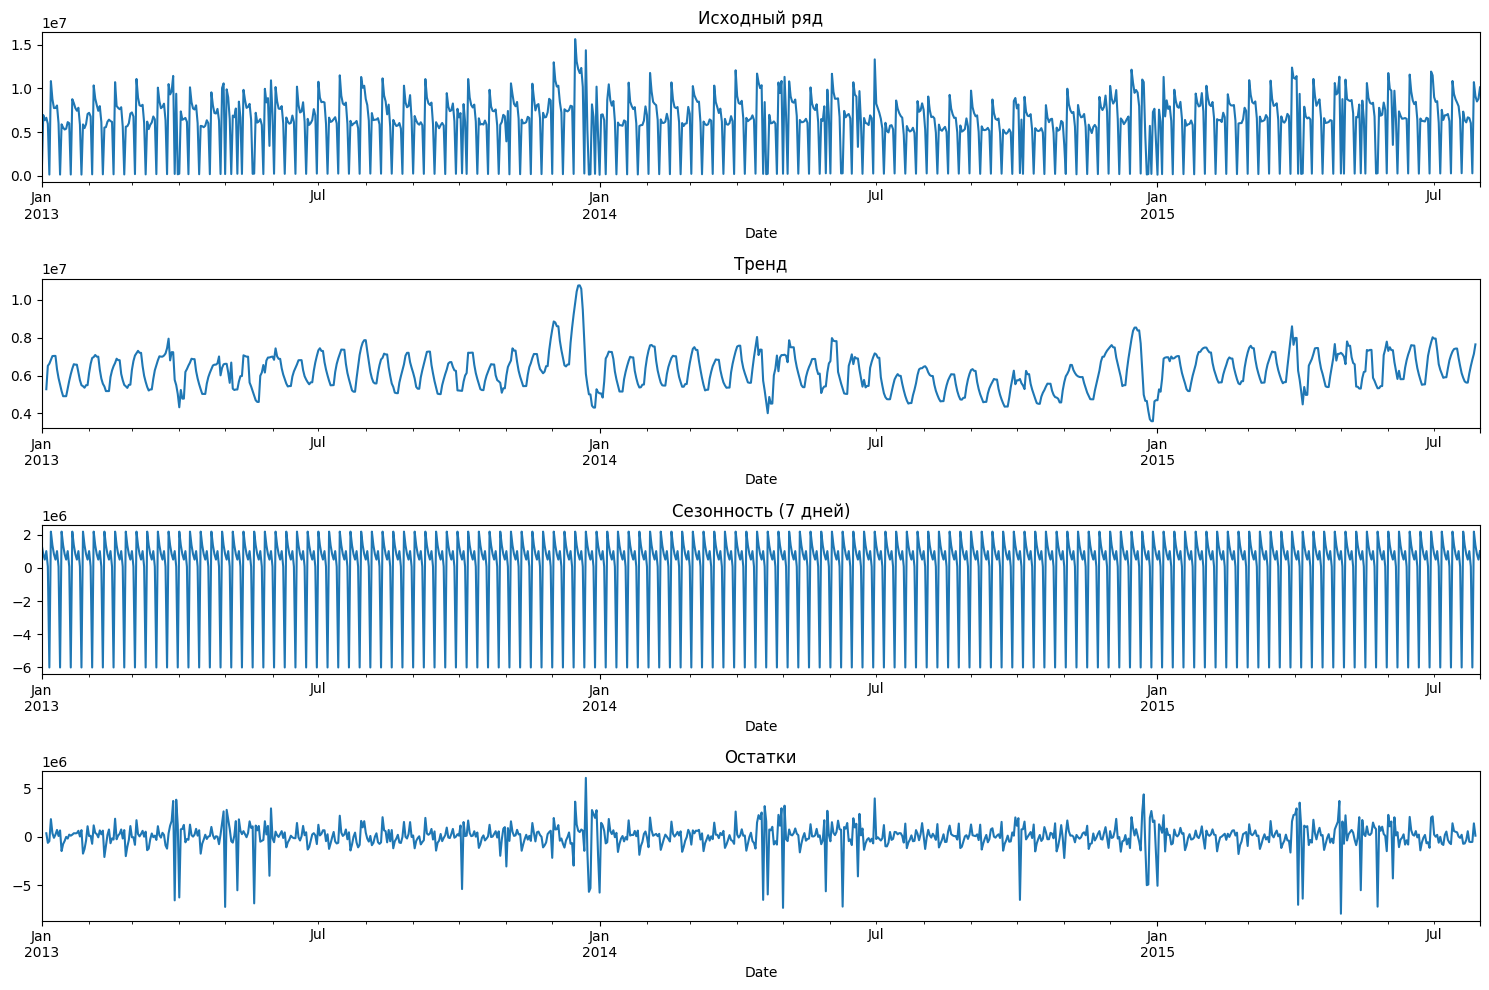

In [11]:
# разложение по годам
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for year in train_merged['Year'].unique():
    yearly = train_merged[train_merged['Year'] == year].groupby('Date')['Sales'].sum()
    axes[0].plot(yearly.index, yearly.values, label=f'{year}', alpha=0.7)
axes[0].set_title('Продажи по годам')
axes[0].legend()

# сезонность. Средние по месяцам во времени
monthly = train_merged.groupby(['Year', 'Month'])['Sales'].mean().reset_index()
monthly['YearMonth'] = pd.to_datetime(monthly[['Year', 'Month']].assign(Day=1))
axes[1].plot(monthly['YearMonth'], monthly['Sales'])
axes[1].set_title('Месячная динамика')

# недельная сезонность во времени
weekly = train_merged.groupby('WeekOfYear')['Sales'].mean()
axes[2].plot(weekly.index, weekly.values)
axes[2].set_title('Средние продажи по неделям года')

plt.tight_layout()
plt.show()

# тренд + сезонность
from statsmodels.tsa.seasonal import seasonal_decompose

daily_sales = train_merged.groupby('Date')['Sales'].sum()
decomposition = seasonal_decompose(daily_sales, model='additive', period=7)

fig, axes = plt.subplots(4, 1, figsize=(15, 10))
decomposition.observed.plot(ax=axes[0], title='Исходный ряд')
decomposition.trend.plot(ax=axes[1], title='Тренд')
decomposition.seasonal.plot(ax=axes[2], title='Сезонность (7 дней)')
decomposition.resid.plot(ax=axes[3], title='Остатки')
plt.tight_layout()
plt.show()

Продажи держатся на плато 6-7М в день без роста, но регулярно же подскакивает до 10. Только два коротковременных провала в январе 2014 и 2015 до 4М после НГ. Декабрь 2013 дает пик примерно 15М, из-за НГ. Тренд слабый.

Сильная циклияность по неделям. Внутри недель амплитуда +-2М каждые 7 дней. Воскресенье всегда провал из-за закрытых магазинов, понедельник всплеск вверх. Паттерн повторяется весь период. Дни недели буду учитывать в моделях, сильный признак.

По годам 2013 и 2014 почти идентичны, 2015 короче но с более высокими пиками. Декабрь взлетает до 15-16М, - в 2-3 раза выше обычного, а в январе обычно спад(ожидаемо). Квартальная сезонность четкая: Q4 лидер, потом Q3, Q2, Q1 худший. Недели 50-52 декабря дают 9500 продаж против базовых 4500-6000, это рождественское безумие.

## Анализ признаков

In [20]:
pd.options.display.float_format = '{:.4f}'.format
train_merged.describe()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,Month,Day,WeekOfYear
count,1017209.0000,1017209.0000,1017209,1017209.0000,1017209.0000,1017209.0000,1017209.0000,1017209.0000,1014567.0000,693861.0000,693861.0000,1017209.0000,509178.0000,509178.0000,1017209.0000,1017209.0000,1017209.0000,1017209.0000
mean,558.4297,3.9983,2014-04-11 01:30:42.846061824,5773.8190,633.1459,0.8301,0.3815,0.1786,5430.0857,7.2229,2008.6902,0.5006,23.2691,2011.7528,2013.8323,5.8468,15.7028,23.6155
min,1.0000,1.0000,2013-01-01 00:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,20.0000,1.0000,1900.0000,0.0000,1.0000,2009.0000,2013.0000,1.0000,1.0000,1.0000
25%,280.0000,2.0000,2013-08-17 00:00:00,3727.0000,405.0000,1.0000,0.0000,0.0000,710.0000,4.0000,2006.0000,0.0000,13.0000,2011.0000,2013.0000,3.0000,8.0000,11.0000
50%,558.0000,4.0000,2014-04-02 00:00:00,5744.0000,609.0000,1.0000,0.0000,0.0000,2330.0000,8.0000,2010.0000,1.0000,22.0000,2012.0000,2014.0000,6.0000,16.0000,22.0000
75%,838.0000,6.0000,2014-12-12 00:00:00,7856.0000,837.0000,1.0000,1.0000,0.0000,6890.0000,10.0000,2013.0000,1.0000,37.0000,2013.0000,2014.0000,8.0000,23.0000,35.0000
max,1115.0000,7.0000,2015-07-31 00:00:00,41551.0000,7388.0000,1.0000,1.0000,1.0000,75860.0000,12.0000,2015.0000,1.0000,50.0000,2015.0000,2015.0000,12.0000,31.0000,52.0000
std,321.9087,1.9974,NaN,3849.9262,464.4117,0.3755,0.4858,0.3831,7715.3237,3.2118,5.9926,0.5000,14.0960,1.6629,0.7774,3.3261,8.7876,14.4334


### Описание признаков c kaggle

Sales - выручка за день в евро, целевая переменная для предсказания.

Customers - количество покупателей посетивших магазин в этот день.

Store - уникальный ID магазина от 1 до 1115.

Date - дата записи продаж.

Open - индикатор был ли магазин открыт в этот день, 0 означает закрыт, 1 открыт.

StateHoliday - государственный праздник, где 0 нет праздника, a публичный праздник, b Пасха, c Рождество. В такие дни большинство магазинов закрыто кроме исключений.

SchoolHoliday - индикатор влияния закрытия школ на продажи в этот день.

StoreType - один из 4 типов магазинов, где a базовый малый, b крупный с высоким трафиком, c средний, d мини у дома.

Assortment - уровень ассортимента товаров, где a базовый, b расширенный, c полный.

CompetitionDistance - расстояние в метрах до ближайшего конкурента.

CompetitionOpenSinceMonth и CompetitionOpenSinceYear - примерные месяц и год когда открылся ближайший конкурент.

Promo - индикатор была ли краткосрочная акция в магазине в этот день.

Promo2 - индикатор участия магазина в долгосрочной непрерывной программе акций, где 0 не участвует, 1 участвует.

Promo2SinceWeek и Promo2SinceYear - неделя и год когда магазин начал участвовать в Promo2.

PromoInterval - интервалы когда запускается Promo2, например "Feb,May,Aug,Nov" означает что каждый раунд стартует в феврале, мае, августе, ноябре любого года для этого магазина.

### Типизация признаков (числовые, категориальные, временные) и их распределения

#### Типизация признаков

In [ ]:
train_merged.dtypes

Store                                 int64
DayOfWeek                             int32
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
Year                                  int32
Month                                 int32
Day                                   int32
WeekOfYear                            int64
dtype: object

Данные состоят из 1.017М записей за период с 2013 по июль 2015 по 1115 магазинам. Всего 22 признака. Из них 4 категориальные (StateHoliday, StoreType, Assortment, PromoInterval), остальные числовые и временные.

Числовые (int64/float64): Sales, Customers, Store, Open, Promo, SchoolHoliday, Promo2, CompetitionDistance, CompetitionOpenSinceMonth, CompetitionOpenSinceYear, Promo2SinceWeek, Promo2SinceYear, Year, Month, Day, WeekOfYear.

Категориальные (object): StateHoliday (0/a/b/c), StoreType (a/b/c/d), Assortment (a/b/c), PromoInterval (строки типа "Feb,May,Aug,Nov").

Временные: Date (datetime64), из которого извлечены Year, Month, Day, WeekOfYear. DayOfWeek формально int32 но дублирует информацию из Date.

#### Распределения

Из describe():

Sales от 0 до 41551, медиана 5744, среднее 5774, std 3850. Много нулей из-за закрытых магазинов, есть правый хвост выбросов до 40к+ в праздники.

Customers от 0 до 7388, медиана 609, среднее 633, std 464. Распределение похоже на Sales, что логично.

CompetitionDistance от 20 до 75860 метров, медиана 2330, среднее 5430, std 7715. Правосторонняя асимметрия, есть магазины с конкурентами очень далеко.

CompetitionOpenSinceMonth от 1 до 12, медиана 8, среднее 7.2. Равномерное распределение по месяцам.

CompetitionOpenSinceYear от 1900 до 2015, медиана 2010, среднее 2009. Год 1900 это явная ошибка в данных.

Promo2SinceWeek от 1 до 50, медиана 22, среднее 23. Покрывает весь год равномерно.

Promo2SinceYear от 2009 до 2015, медиана 2012, среднее 2012. Программа Promo2 запущена в 2009 году.

Open бинарный, 83% это 1 (открыт), 17% это 0 (закрыт).

SchoolHoliday бинарный, 18% это 1 (каникулы), 82% это 0.

Promo бинарный, 38% это 1 (акция), 62% это 0.

Promo2 бинарный, 50% это 1 (участвует), 50% это 0.

StateHoliday категориальный, преобладают нули (обычные дни), праздники a/b/c редкие события.

StoreType категориальный с 4 уровнями a/b/c/d, распределение по типам неравномерное.

Assortment категориальный с 3 уровнями a/b/c, распределение неравномерное.

PromoInterval категориальный, несколько вариантов комбинаций месяцев типа "Jan,Apr,Jul,Oct" или "Feb,May,Aug,Nov".


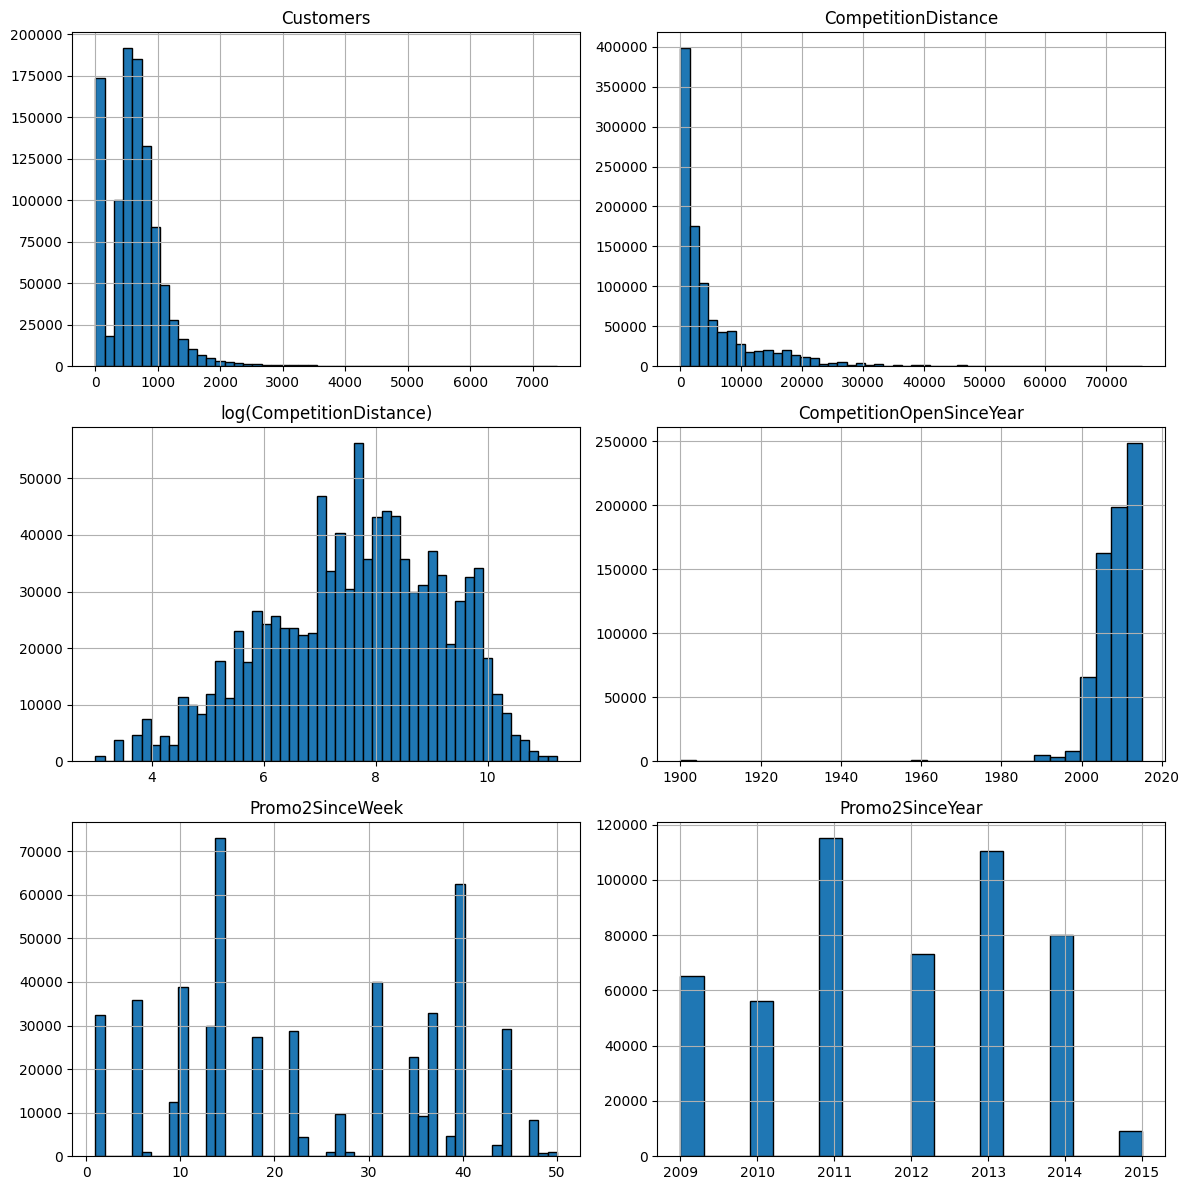

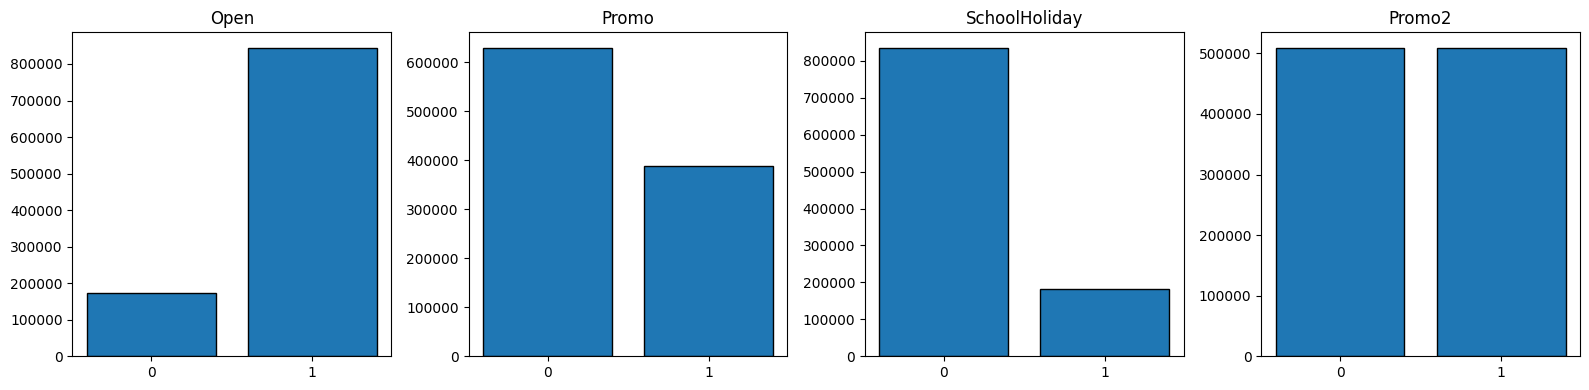

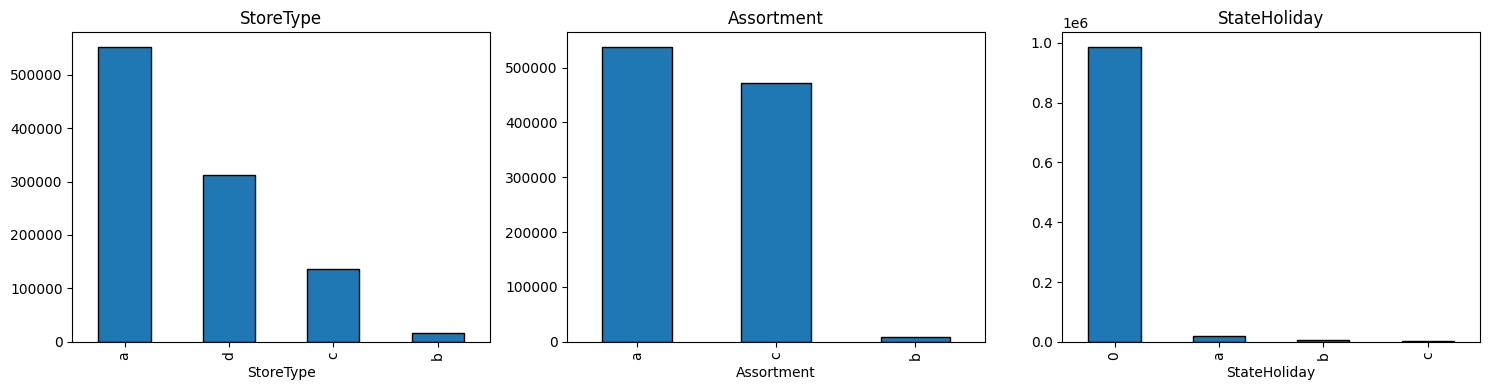

In [24]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

train_merged['Customers'].hist(bins=50, ax=axes[0], edgecolor='black')
axes[0].set_title('Customers')

train_merged['CompetitionDistance'].hist(bins=50, ax=axes[1], edgecolor='black')
axes[1].set_title('CompetitionDistance')

train_merged[train_merged['CompetitionDistance']>0]['CompetitionDistance'].apply(np.log).hist(bins=50, ax=axes[2], edgecolor='black')
axes[2].set_title('log(CompetitionDistance)')

train_merged['CompetitionOpenSinceYear'].hist(bins=30, ax=axes[3], edgecolor='black')
axes[3].set_title('CompetitionOpenSinceYear')

train_merged['Promo2SinceWeek'].dropna().hist(bins=50, ax=axes[4], edgecolor='black')
axes[4].set_title('Promo2SinceWeek')

train_merged['Promo2SinceYear'].dropna().hist(bins=20, ax=axes[5], edgecolor='black')
axes[5].set_title('Promo2SinceYear')

plt.tight_layout()
plt.show()

# Бинарные признаки
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

binary_features = ['Open', 'Promo', 'SchoolHoliday', 'Promo2']
for idx, feat in enumerate(binary_features):
    counts = train_merged[feat].value_counts()
    axes[idx].bar(counts.index, counts.values, edgecolor='black')
    axes[idx].set_title(f'{feat}')
    axes[idx].set_xticks([0, 1])

plt.tight_layout()
plt.show()

# Категориальные признаки
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

train_merged['StoreType'].value_counts().plot(kind='bar', ax=axes[0], edgecolor='black')
axes[0].set_title('StoreType')

train_merged['Assortment'].value_counts().plot(kind='bar', ax=axes[1], edgecolor='black')
axes[1].set_title('Assortment')

train_merged['StateHoliday'].value_counts().plot(kind='bar', ax=axes[2], edgecolor='black')
axes[2].set_title('StateHoliday')

plt.tight_layout()
plt.show()

Sales и Customers похожи по форме. С одинаковой правосторонней асимметрией. Концентрируются слева и с длинным хвостом справа. Customers аналогично: пик у нуля, основная масса 200-1000, хвост до 7000.

CompetitionDistance до 75км, большинство магазинов имеют конкурента в радиусе 5км. После логарифмирования распределение похоже на нормальное. Признак лучше использовать в log-шкале.

CompetitionOpenSinceYear показывает аномалию 1900 года. Видимо ошибка в данных, основная масса открытий конкурентов после 2000 года с пиком в 2010-2015. Promo2SinceWeek равномерный с выбросами на 40 и 14 неделях

Promo2SinceYear концентрируется в 2011-2013. В 2015 таких событий было мало.

Open показывает 83% открытых дней против 17% закрытых, Promo 38% дней с акцией против 62% без, SchoolHoliday 18% дней с каникулами, Promo2 ровно 50/50 разделение магазинов. StoreType сильно перекошен в сторону a (почти 55%), тип b второй по популярности (30%), типы c и d редкие (13% и 2%). Assortment тоже неравномерный: базовый a и расширенный c примерно поровну (по 53% и 45%), а полный b всего в 2% магазинов. StateHoliday почти всегда ноль (тоже логично), праздники a/b/c единичные события. Видимо признак будет довольно слабым так как почти const.

### Выявление и изучение аномальных значений и анализ пропущенных значений

#### Аномалии

In [48]:
# странные комбинации sales/customers при открытом магазине
print("Аномалии в Open=1:")
open_zeros = (train_merged['Open']==1) & (train_merged['Sales']==0) & (train_merged['Customers']==0)
print(f"  Sales=0 и Customers=0: {open_zeros.sum()} записей")
print(f"  Затронуто магазинов: {train_merged[open_zeros]['Store'].nunique()}")

# чек почти ноль при наличии клиентов
sales_per_customer = train_merged[train_merged['Customers']>0]['Sales'] / train_merged[train_merged['Customers']>0]['Customers']
weird_cheap = (train_merged['Customers']>0) & (sales_per_customer<1)
print(f"\nЧек <1 евро при наличии клиентов: {weird_cheap.sum()} записей")
print("Детали:")
print(train_merged[weird_cheap][['Store', 'Date', 'Sales', 'Customers', 'Open', 'Promo']])

print(f"\nВозможные заглушки:")
print(f"  CompetitionOpenSinceYear=1900: {(train_merged['CompetitionOpenSinceYear']==1900).sum()} записей")
print(f"  CompetitionOpenSinceYear <2000: {(train_merged['CompetitionOpenSinceYear']<2000).sum()} записей")
print(f"  CompetitionDistance=20м (минимум): {(train_merged['CompetitionDistance']==20).sum()} записей")

print(f"\nПропуски:")
missing_year = train_merged['CompetitionOpenSinceYear'].isna().sum()
print(f"  CompetitionOpenSinceYear: {missing_year} ({missing_year/len(train_merged)*100:.0f}%)")
has_dist_no_year = ((train_merged['CompetitionDistance'].notna()) & (train_merged['CompetitionOpenSinceYear'].isna())).sum()
print(f"  Есть distance но нет года открытия: {has_dist_no_year}")
print(f"  CompetitionDistance: {train_merged['CompetitionDistance'].isna().sum()}")

print(f"\nВыбросы:")
print(f"  Sales >30k: {(train_merged['Sales']>30000).sum()} записей (max={train_merged['Sales'].max()})")
print(f"  Sales топ 0.1%: >{train_merged['Sales'].quantile(0.999):.0f}")
print(f"  Customers >5k: {(train_merged['Customers']>5000).sum()} записей (max={train_merged['Customers'].max()})")
print(f"  Customers топ 0.1%: >{train_merged['Customers'].quantile(0.999):.0f}")
print(f"  CompetitionDistance >50км: {(train_merged['CompetitionDistance']>50000).sum()} записей (max={train_merged['CompetitionDistance'].max()/1000:.1f}км)")

Аномалии в Open=1:
  Sales=0 и Customers=0: 52 записей
  Затронуто магазинов: 40

Чек <1 евро при наличии клиентов: 2 записей
Детали:
        Store       Date  Sales  Customers  Open  Promo
478649   1100 2014-04-29      0          3     1      1
889932    948 2013-04-25      0          5     1      1

Возможные заглушки:
  CompetitionOpenSinceYear=1900: 758 записей
  CompetitionOpenSinceYear <2000: 18288 записей
  CompetitionDistance=20м (минимум): 942 записей

Пропуски:
  CompetitionOpenSinceYear: 323348 (32%)
  Есть distance но нет года открытия: 320706
  CompetitionDistance: 2642

Выбросы:
  Sales >30k: 153 записей (max=41551)
  Sales топ 0.1%: >23980
  Customers >5k: 19 записей (max=7388)
  Customers топ 0.1%: >3582
  CompetitionDistance >50км: 1884 записей (max=75.9км)


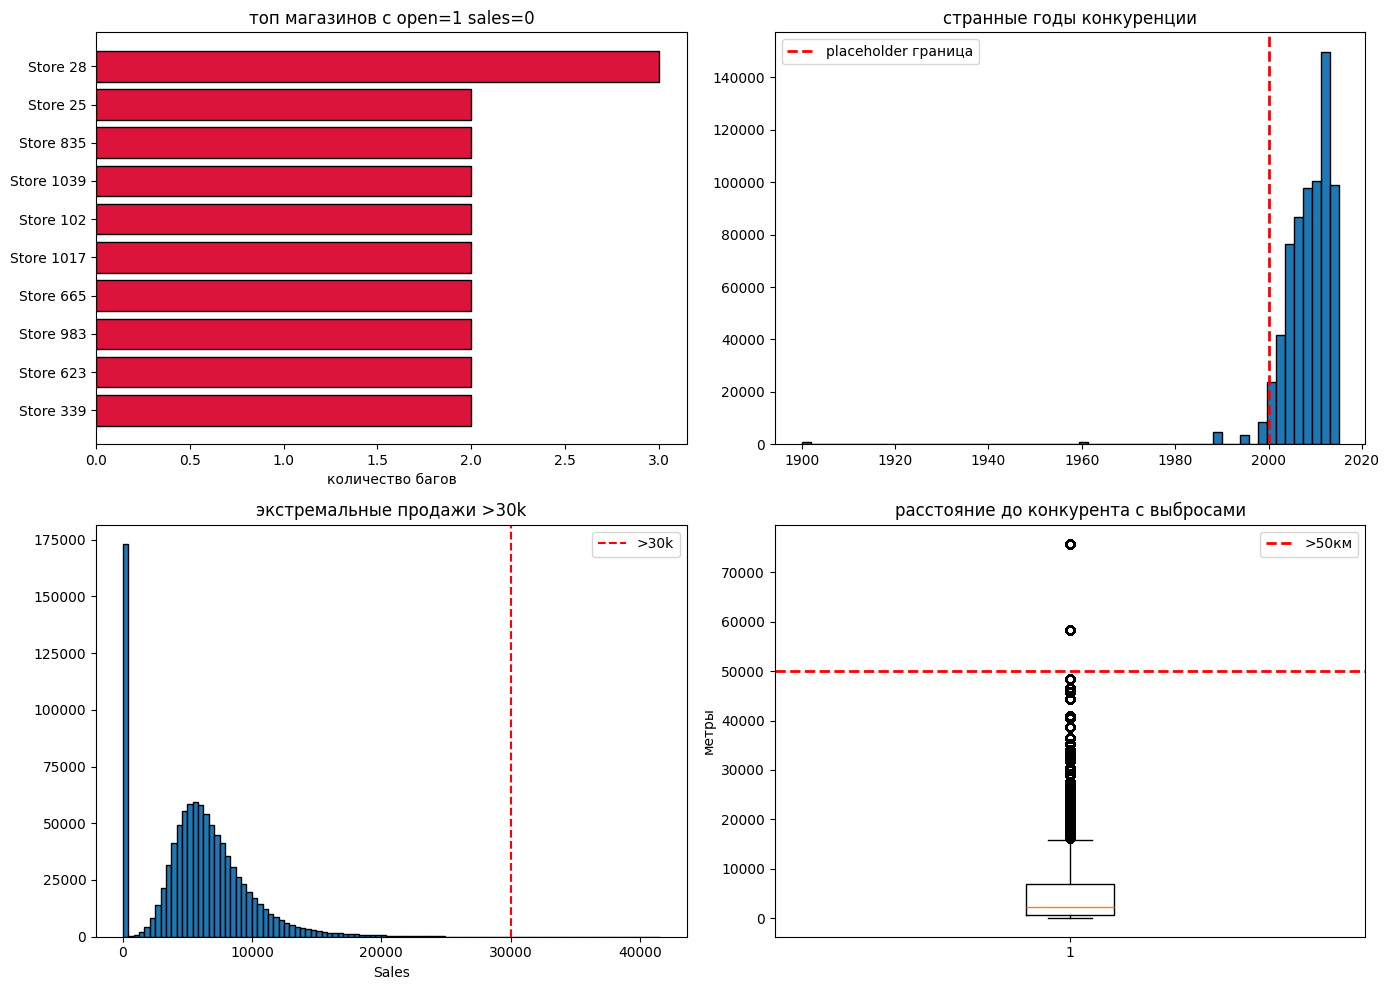

In [51]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# баги sales=0 при open=1 - распределение по магазинам
open_zeros = train_merged[(train_merged['Open']==1) & (train_merged['Sales']==0) & (train_merged['Customers']==0)]
bug_counts = open_zeros.groupby('Store').size().sort_values(ascending=False).head(10)
axes[0,0].barh(range(len(bug_counts)), bug_counts.values, edgecolor='black', color='crimson')
axes[0,0].set_yticks(range(len(bug_counts)))
axes[0,0].set_yticklabels([f'Store {s}' for s in bug_counts.index])
axes[0,0].set_xlabel('количество багов')
axes[0,0].set_title('топ магазинов с open=1 sales=0')
axes[0,0].invert_yaxis()

# placeholders в годах
axes[0,1].hist(train_merged['CompetitionOpenSinceYear'].dropna(), bins=60, edgecolor='black')
axes[0,1].axvline(2000, color='red', linestyle='--', linewidth=2, label='placeholder граница')
axes[0,1].set_title('странные годы конкуренции')
axes[0,1].legend()

# выбросы в sales
axes[1,0].hist(train_merged['Sales'], bins=100, edgecolor='black')
axes[1,0].axvline(30000, color='red', linestyle='--', label='>30k')
axes[1,0].set_xlabel('Sales')
axes[1,0].set_title('экстремальные продажи >30k')
axes[1,0].legend()

# выбросы в competition distance
axes[1,1].boxplot(train_merged['CompetitionDistance'].dropna())
axes[1,1].axhline(50000, color='red', linestyle='--', linewidth=2, label='>50км')
axes[1,1].set_ylabel('метры')
axes[1,1].set_title('расстояние до конкурента с выбросами')
axes[1,1].legend()

plt.tight_layout()
plt.show()

В итоге:

Есть неправильно заполненные строки (54 штуки): 52 строки когда магазин открыт но продаж и клиентов ноль, плюс 2 записи где клиенты есть а продажи нулевые. Затрагивает 40 магазинов. Таких значений мало. Можно дропныть.

Заглушки (19к записей): Год 1900 и даты до 2000 года для CompetitionOpenSinceYear - заглушки. Еще странные 942 записи с distance=20м тоже похожи на заклушку. Хотя, конкурент в 20 метрах реален в тц. например.

Выбросы (2к+ записей): 153 дня с продажами выше 30k, 19 дней с клиентами больше 5k, 1884 магазина с конкурентом дальше 50км. Не думаю, что это ошибки в данных. Скорее всего, выбросы.

Пропуски (32% данных): Треть записей не знает год открытия конкурента, хотя знает расстояние до него. Самая большая дыра в данных. Думаю, придется создать бинарный признак "есть ли инфа о конкуренте".

#### Пропуски

In [ ]:
# все пропуски
print("Пропуски по всем столбцам:")
print(train_merged.isnull().sum()[train_merged.isnull().sum() > 0])

print("\nMedian Sales:")
print(f"С годом конкурента: {train_merged[train_merged['CompetitionOpenSinceYear'].notna()]['Sales'].median():.0f}")
print(f"Без года: {train_merged[train_merged['CompetitionOpenSinceYear'].isna()]['Sales'].median():.0f}")

# уникальные магазины с пропусками
print(f"\nМагазинов без года: {train_merged[train_merged['CompetitionOpenSinceYear'].isna()]['Store'].nunique()}")
print(f"Магазинов без distance: {train_merged[train_merged['CompetitionDistance'].isna()]['Store'].nunique()}")

Пропуски по всем столбцам:
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

Median Sales:
С годом конкурента: 5743
Без года: 5746

Магазинов без года: 354
Магазинов без distance: 3


In [ ]:
def check_timeseries_correctness(df, name='dataset'):    
    print(f"{name}:\n")
    
    # диапазон дат
    date_range = pd.date_range(df['Date'].min(), df['Date'].max(), freq='D')
    all_stores = df['Store'].unique()
    
    print(f"Период: {df['Date'].min().date()} - {df['Date'].max().date()}")
    print(f"Дней: {len(date_range)}")
    print(f"Магазинов: {len(all_stores)}")
    
    expected = len(date_range) * len(all_stores)
    actual = len(df)
    print(f"\nОжидаемо записей: {expected}")
    print(f"Фактически: {actual}")
    print(f"Покрытие: {actual/expected*100:.1f}%")
    
    # проверка по магазинам
    records_per_store = df.groupby('Store').size()
    incomplete_stores = records_per_store[records_per_store < len(date_range)]
    print(f"\nМагазинов с пропусками дат: {len(incomplete_stores)}")
    if len(incomplete_stores) > 0:
        print("Примеры худших:")
        print(incomplete_stores.sort_values().head())
    
    records_per_date = df.groupby('Date').size()
    incomplete_dates = records_per_date[records_per_date < len(all_stores)]
    print(f"\nДат с пропусками магазинов: {len(incomplete_dates)}")
    if len(incomplete_dates) > 0:
        print("Примеры:")
        print(incomplete_dates.head())
    
    # дубликаты
    duplicates = df[df.duplicated(subset=['Store', 'Date'], keep=False)]
    print(f"\nДубликаты Store+Date: {len(duplicates)}")
    
    # хронологический порядок
    is_sorted = df['Date'].is_monotonic_increasing
    print(f"Отсортировано по дате: {is_sorted}")
    
    all_dates = set(date_range)
    actual_dates = set(df['Date'].unique())
    missing_dates = all_dates - actual_dates
    print(f"\nПолностью отсутствующих дат: {len(missing_dates)}")
    if len(missing_dates) > 0 and len(missing_dates) < 10:
        print(f"Даты: {sorted(missing_dates)}")
    
    print()
    return {
        'stores': all_stores,
        'date_range': date_range,
        'dates': actual_dates,
        'coverage': actual/expected
    }

train_info = check_timeseries_integrity(train_merged, 'train')
test_info = check_timeseries_integrity(test_merged, 'test')

print("train vs test:\n")

train_stores = set(train_info['stores'])
test_stores = set(test_info['stores'])

print(f"Магазинов train: {len(train_stores)}, test: {len(test_stores)}")
print(f"Пересечение: {len(train_stores & test_stores)}")
print(f"Только в train: {len(train_stores - test_stores)}")
print(f"Только в test: {len(test_stores - train_stores)}")

if len(test_stores - train_stores) > 0:
    print(f"Новые магазины в test: {sorted(test_stores - train_stores)[:10]}")

print(f"\nПоследняя train: {max(train_info['dates']).date()}")
print(f"Первая test: {min(test_info['dates']).date()}")
print(f"Последняя test: {max(test_info['dates']).date()}")

overlap = train_info['dates'] & test_info['dates']
print(f"Пересечение дат: {len(overlap)}")

train:

Период: 2013-01-01 - 2015-07-31
Дней: 942
Магазинов: 1115

Ожидаемо записей: 1050330
Фактически: 1017209
Покрытие: 96.8%

Магазинов с пропусками дат: 181
Примеры худших:
Store
13     758
694    758
701    758
702    758
706    758
dtype: int64

Дат с пропусками магазинов: 185
Примеры:
Date
2013-01-01    1114
2014-07-01     935
2014-07-02     935
2014-07-03     935
2014-07-04     935
dtype: int64

Дубликаты Store+Date: 0
Отсортировано по дате: False

Полностью отсутствующих дат: 0

test:

Период: 2015-08-01 - 2015-09-17
Дней: 48
Магазинов: 856

Ожидаемо записей: 41088
Фактически: 41088
Покрытие: 100.0%

Магазинов с пропусками дат: 0

Дат с пропусками магазинов: 0

Дубликаты Store+Date: 0
Отсортировано по дате: False

Полностью отсутствующих дат: 0

train vs test:

Магазинов train: 1115, test: 856
Пересечение: 856
Только в train: 259
Только в test: 0

Последняя train: 2015-07-31
Первая test: 2015-08-01
Последняя test: 2015-09-17
Пересечение дат: 0


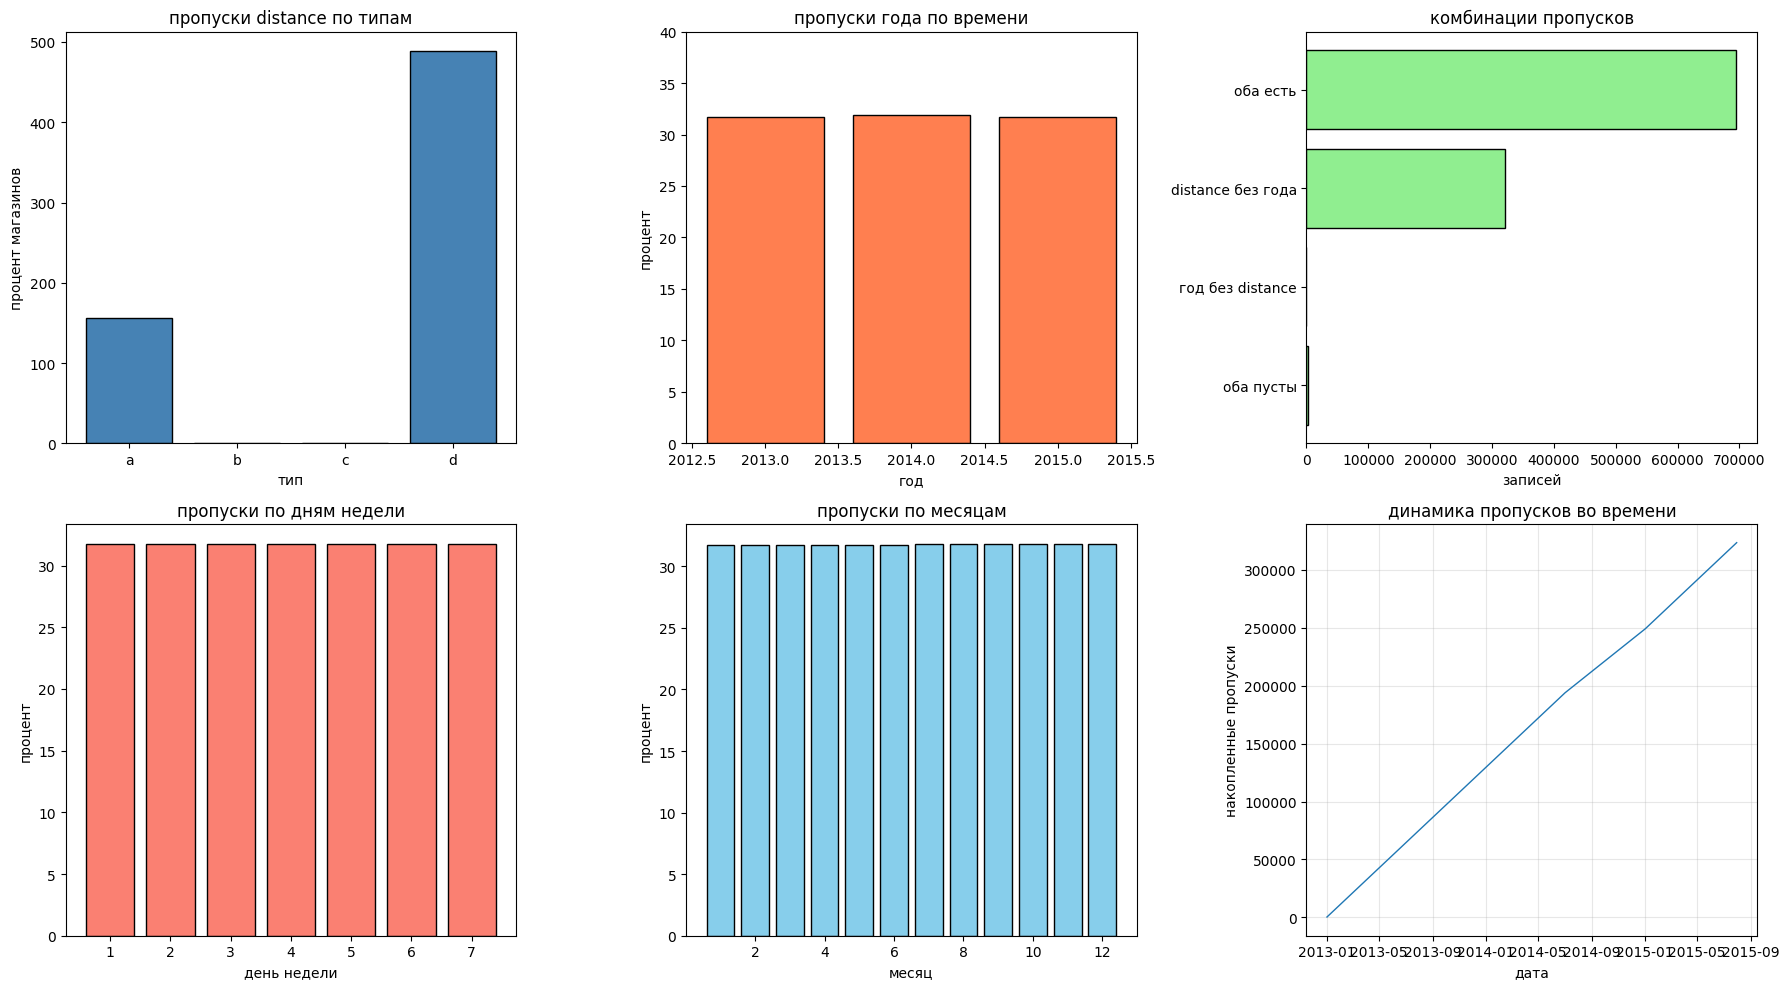

In [62]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# пропуски distance по типам
no_dist = train_merged[train_merged['CompetitionDistance'].isna()].groupby('StoreType').size()
total_by_type = train_merged.groupby('StoreType')['Store'].nunique()
pct_by_type = (no_dist / total_by_type * 100).fillna(0)

axes[0,0].bar(pct_by_type.index, pct_by_type.values, edgecolor='black', color='steelblue')
axes[0,0].set_ylabel('процент магазинов')
axes[0,0].set_title('пропуски distance по типам')
axes[0,0].set_xlabel('тип')

# пропуски года по годам
missing_year_by_time = train_merged.groupby('Year').apply(
    lambda x: x['CompetitionOpenSinceYear'].isna().sum() / len(x) * 100,
    include_groups=False
)
axes[0,1].bar(missing_year_by_time.index, missing_year_by_time.values, edgecolor='black', color='coral')
axes[0,1].set_ylabel('процент')
axes[0,1].set_title('пропуски года по времени')
axes[0,1].set_xlabel('год')
axes[0,1].set_ylim(0, 40)

# паттерны пропусков
has_both = train_merged['CompetitionDistance'].notna() & train_merged['CompetitionOpenSinceYear'].notna()
has_dist_no_year = train_merged['CompetitionDistance'].notna() & train_merged['CompetitionOpenSinceYear'].isna()
has_year_no_dist = train_merged['CompetitionDistance'].isna() & train_merged['CompetitionOpenSinceYear'].notna()
has_none = train_merged['CompetitionDistance'].isna() & train_merged['CompetitionOpenSinceYear'].isna()

pattern_counts = pd.Series({
    'оба есть': has_both.sum(),
    'distance без года': has_dist_no_year.sum(),
    'год без distance': has_year_no_dist.sum(),
    'оба пусты': has_none.sum()
})

axes[0,2].barh(range(len(pattern_counts)), pattern_counts.values, edgecolor='black', color='lightgreen')
axes[0,2].set_yticks(range(len(pattern_counts)))
axes[0,2].set_yticklabels(pattern_counts.index)
axes[0,2].set_xlabel('записей')
axes[0,2].set_title('комбинации пропусков')
axes[0,2].invert_yaxis()

# пропуски по дням недели
missing_by_dow = train_merged.groupby('DayOfWeek').apply(
    lambda x: x['CompetitionOpenSinceYear'].isna().sum() / len(x) * 100,
    include_groups=False
)
axes[1,0].bar(missing_by_dow.index, missing_by_dow.values, edgecolor='black', color='salmon')
axes[1,0].set_xlabel('день недели')
axes[1,0].set_ylabel('процент')
axes[1,0].set_title('пропуски по дням недели')

# пропуски по месяцам
missing_by_month = train_merged.groupby('Month').apply(
    lambda x: x['CompetitionOpenSinceYear'].isna().sum() / len(x) * 100,
    include_groups=False
)
axes[1,1].bar(missing_by_month.index, missing_by_month.values, edgecolor='black', color='skyblue')
axes[1,1].set_xlabel('месяц')
axes[1,1].set_ylabel('процент')
axes[1,1].set_title('пропуски по месяцам')

# накопленные пропуски по времени
daily_missing = train_merged.groupby('Date')['CompetitionOpenSinceYear'].apply(lambda x: x.isna().sum())
cumsum_missing = daily_missing.cumsum()

axes[1,2].plot(daily_missing.index, cumsum_missing.values, linewidth=1)
axes[1,2].set_xlabel('дата')
axes[1,2].set_ylabel('накопленные пропуски')
axes[1,2].set_title('динамика пропусков во времени')
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

CompetitionOpenSinceYear отсутствует у 354 магазинов (32% данных). Из них 3 не знают вообще ничего про конкурентов, остальные 351 знают distance но не знают когда конкурент открылся. Пропуски равномерно распределены по времени, дням недели и месяцам. Получается, это специфика датасете.

Promo2SinceWeek/Year и PromoInterval пропущены у 508к записей (50%). Половина не участвует. Для них Promo2=0 и все три поля логично пустые.

Целостность временного ряда:

Train покрывает 96.8% ожидаемых записей (33к пропусков). 181 магазин имеют неполные даты, причем у некоторых отсутствует по 758 дней из 942. Еще 185 дат имеют неполный набор магазинов.

В теста 100% покрытие, все 856 магазинов присутствуют во всех 48 днях. Все тестовые магазины есть в train. Даты не пересекаются с train (последний день train 31 июля, первый test 1 августа).

Данные не отсортированы по дате.

### Анализ зависимостей между признаками

In [71]:
def plot_target_vs_features(df, target, features, plot_type='box', figsize=(18, 5)):
    n_cols = len(features)
    fig, axes = plt.subplots(1, n_cols, figsize=figsize)
    
    if n_cols == 1: axes = [axes]
    
    for ax, col in zip(axes, features):
        if plot_type == 'box':
            sns.boxplot(x=col, y=target, data=df, ax=ax)
        elif plot_type == 'bar':
            sns.barplot(x=col, y=target, data=df, ax=ax)
            
        ax.set_title(f'{target} vs {col}')
        
    plt.tight_layout()
    plt.show()

Columns for pairplot: ['Sales', 'Customers', 'CompetitionDistance', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'Year']


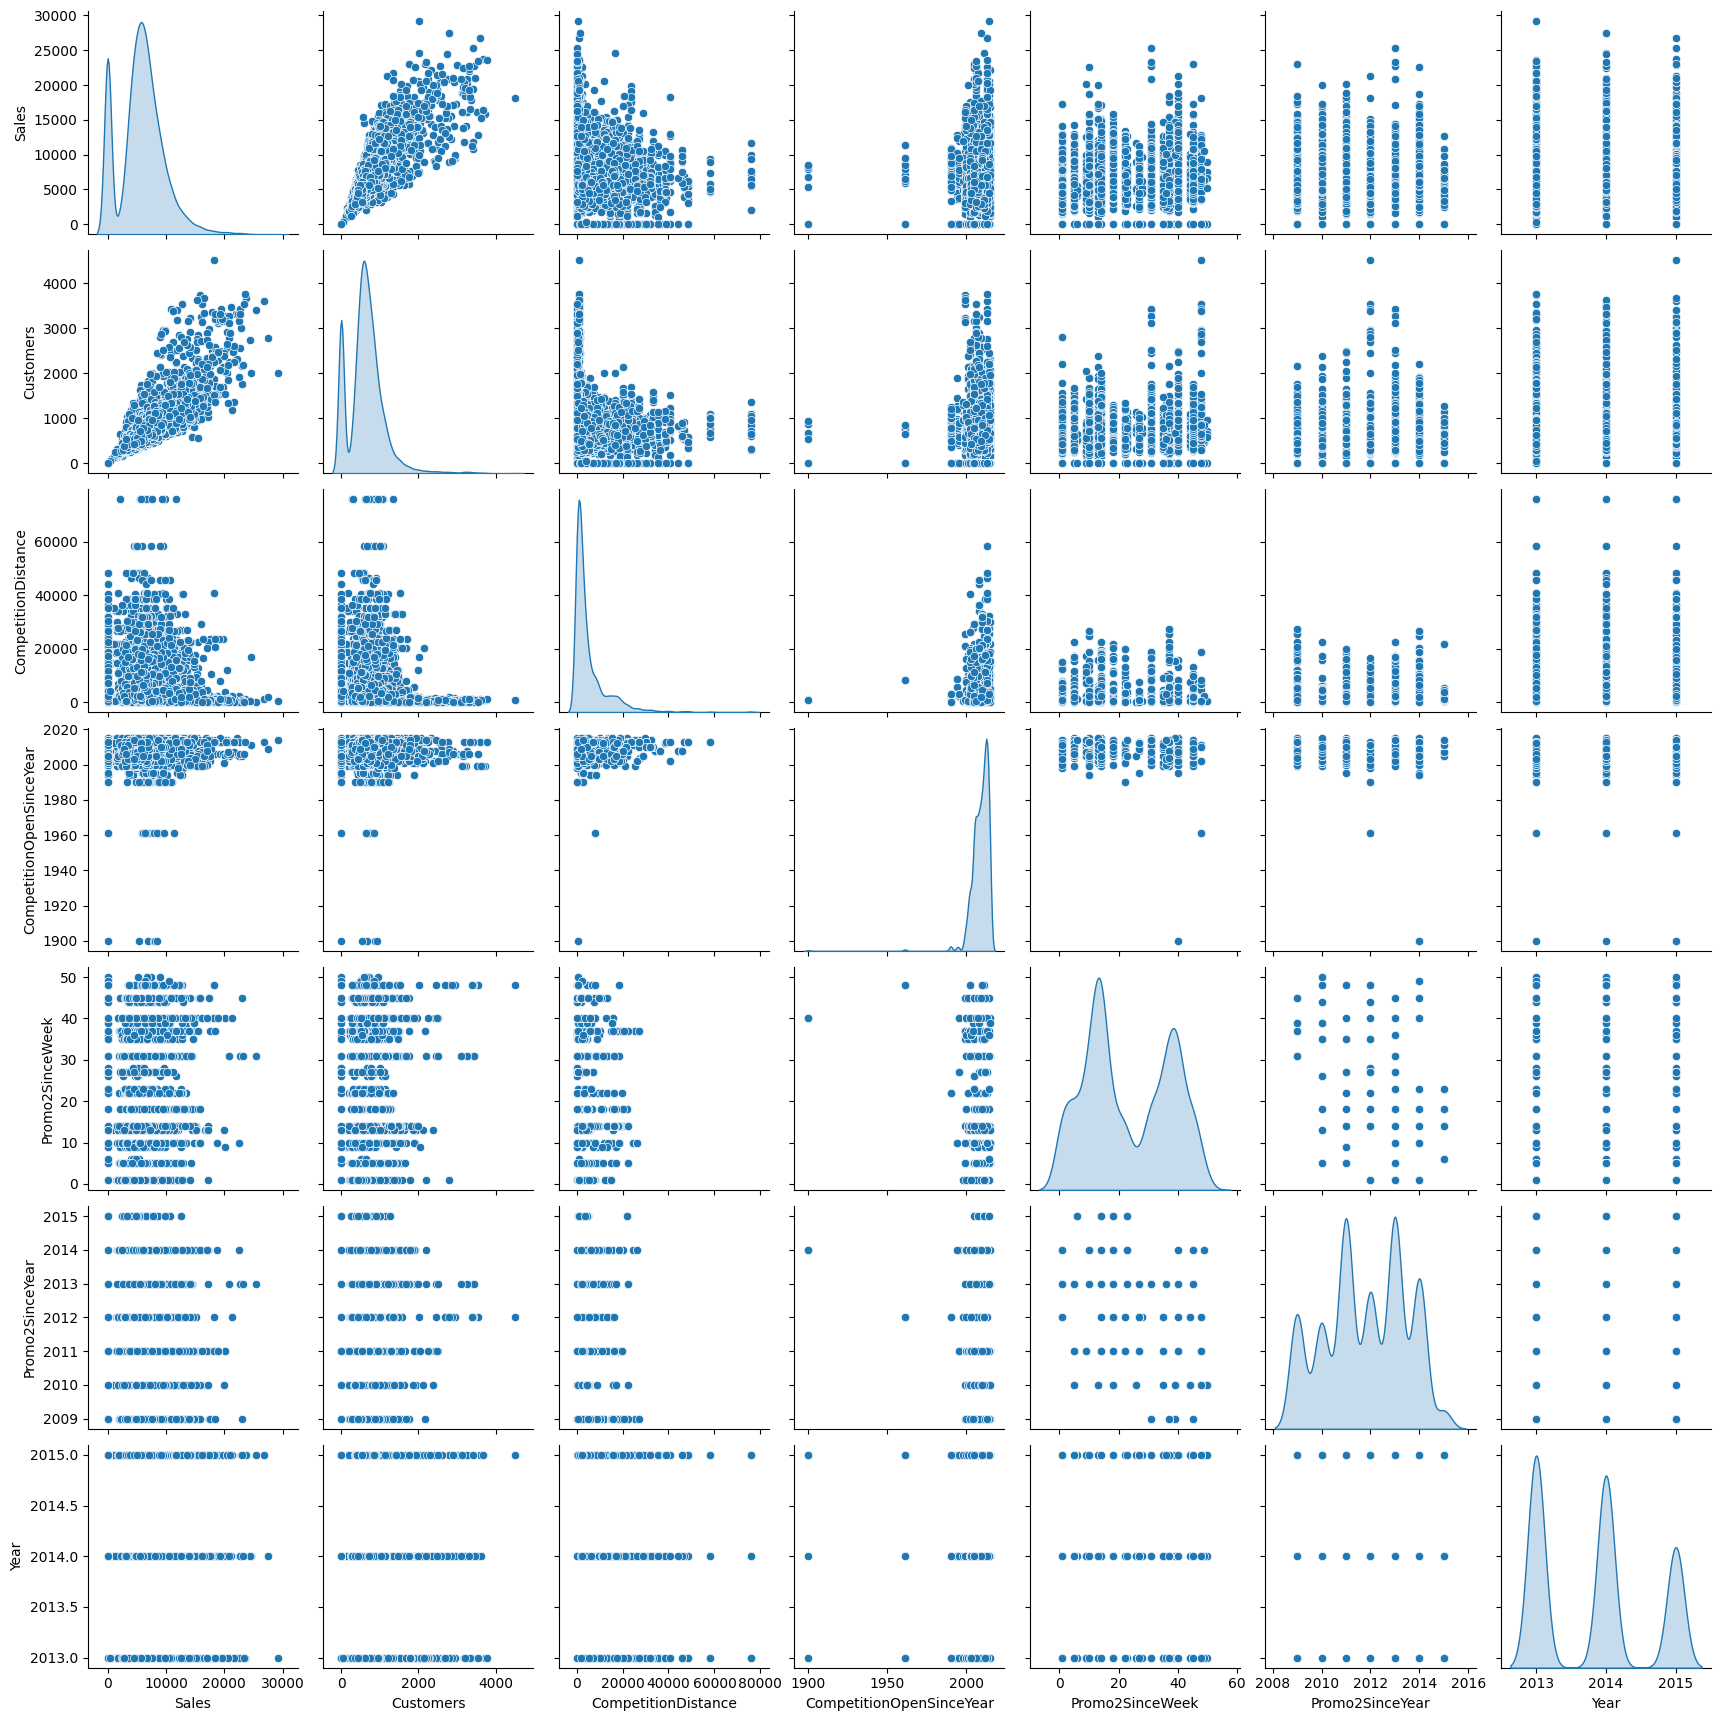

In [ ]:
# Remove unnecessary features like 'Id'
cols_to_exclude = ['Id', 'Store', 'Date', 'SchoolHoliday', 'IsStateHoliday', 'Month', 'DayOfWeek', 'Open', 'Promo', 'Day', 
                   'WeekOfYear', 'CompetitionOpenSinceMonth', 'Promo2']


numeric_cols = train_merged.select_dtypes(include=[np.number]).columns.tolist()
pairplot_cols = [c for c in numeric_cols if c not in cols_to_exclude]

if 'Id' in pairplot_cols:
    pairplot_cols.remove('Id')

print("Columns for pairplot:", pairplot_cols)

sample_df = train_merged[pairplot_cols].sample(min(10000, len(train_merged)), random_state=42)

sns.pairplot(sample_df, diag_kind='kde')
plt.show()

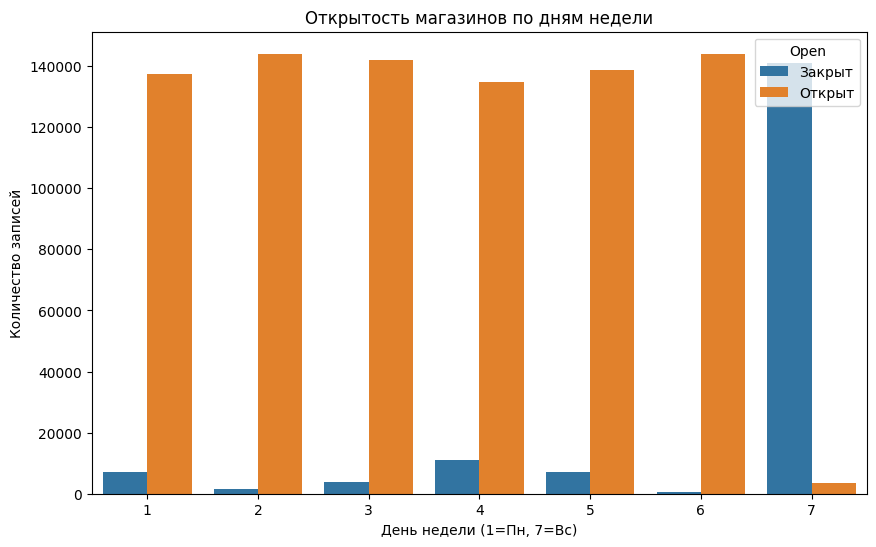

In [68]:
plt.figure(figsize=(10, 6))
open_by_dow = train_merged.groupby(['DayOfWeek', 'Open']).size().reset_index(name='Count')
open_by_dow['Open'] = open_by_dow['Open'].map({0: 'Закрыт', 1: 'Открыт'})

sns.barplot(x='DayOfWeek', y='Count', hue='Open', data=open_by_dow)
plt.title('Открытость магазинов по дням недели')
plt.xlabel('День недели (1=Пн, 7=Вс)')
plt.ylabel('Количество записей')
plt.show()

Чаще всего в воскресенье магазины закрыты

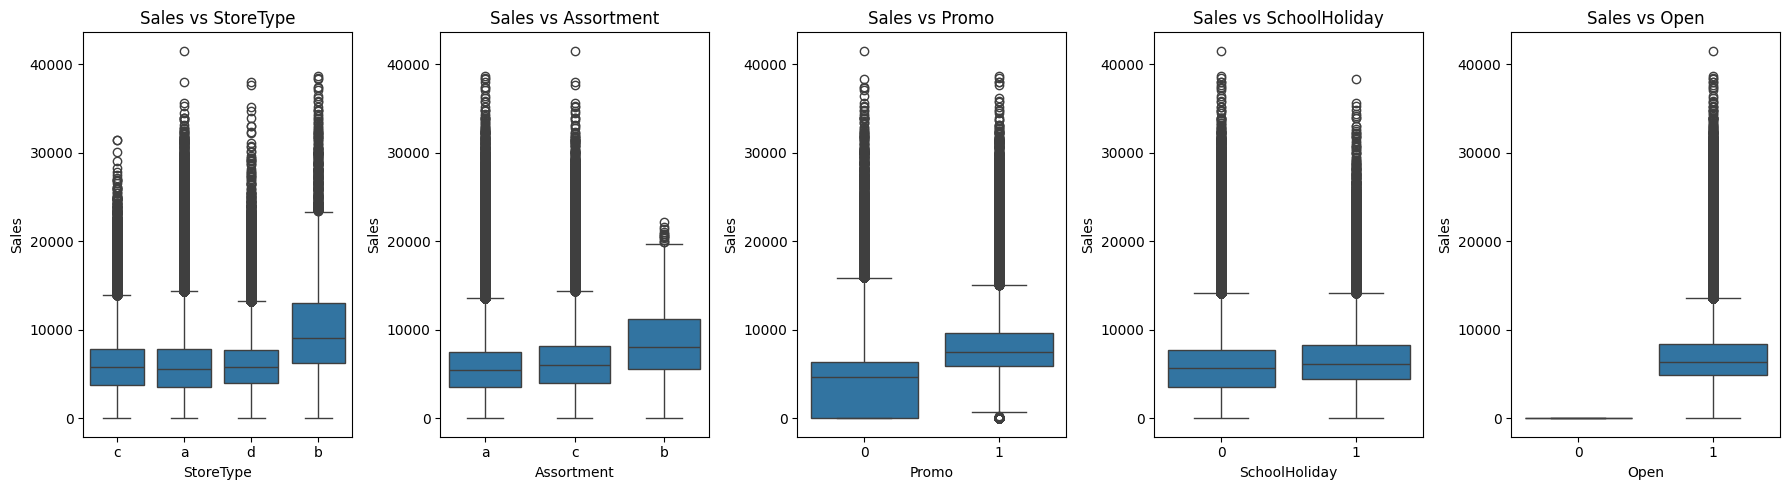

In [72]:
# Анализ влияния категорий на Продажи
cols_to_plot = ['StoreType', 'Assortment', 'Promo', 'SchoolHoliday', 'Open']
plot_target_vs_features(train_merged, 'Sales', cols_to_plot, plot_type='box')

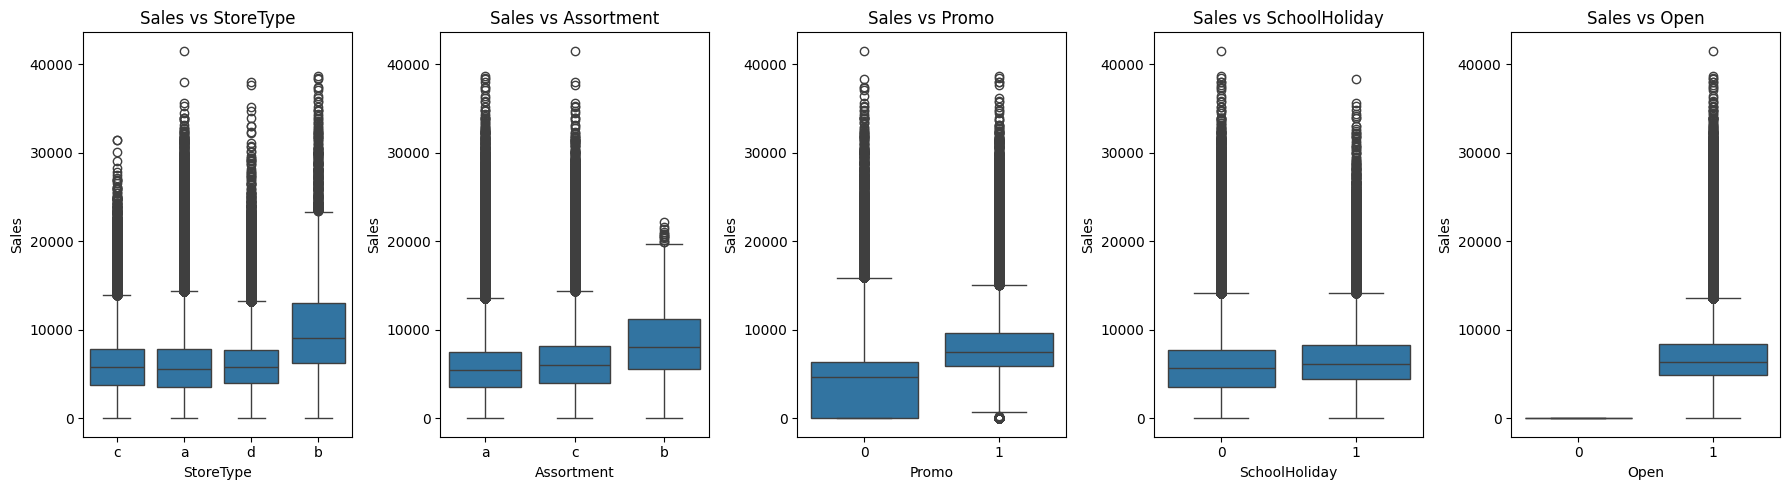

In [73]:
# Анализ влияния категорий на Продажи
cols_to_plot = ['StoreType', 'Assortment', 'Promo', 'SchoolHoliday', 'Open']
plot_target_vs_features(train_merged, 'Sales', cols_to_plot, plot_type='box')

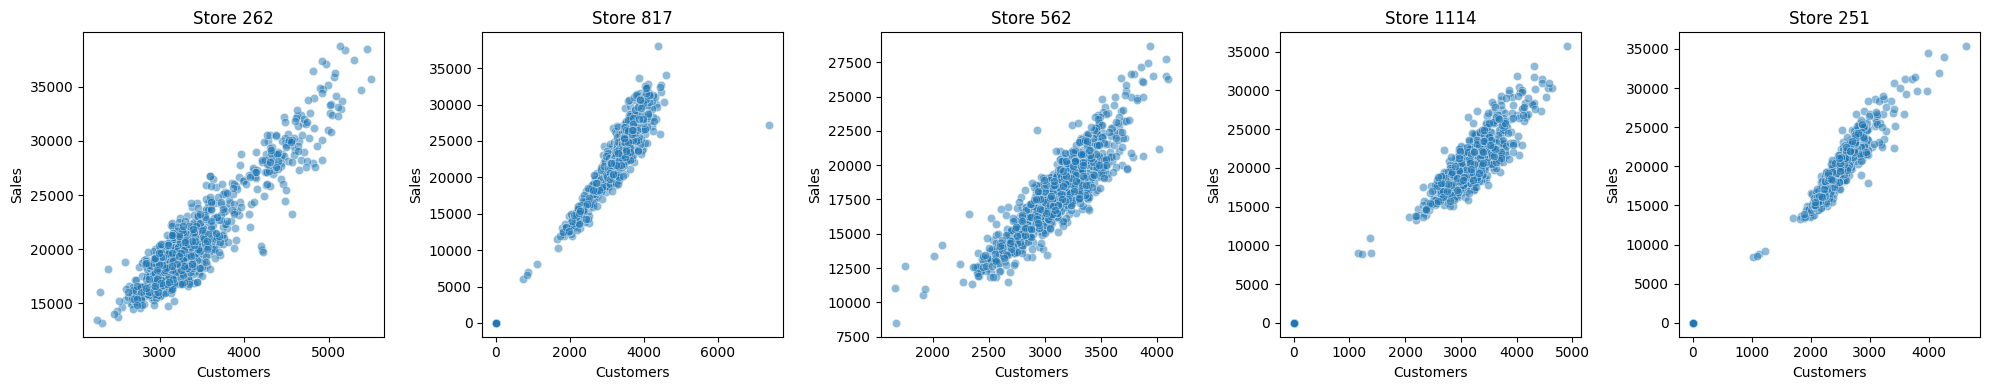

In [71]:
# Глянем на топ магазинов по продажам и их зависимость от кол-во клиентов
top5_stores = train_merged.groupby('Store')['Sales'].sum().nlargest(5).index

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for idx, store in enumerate(top5_stores):
    store_data = train_merged[train_merged['Store'] == store]

    sns.scatterplot(
        data=store_data,
        x='Customers',
        y='Sales',
        alpha=0.5,
        ax=axes[idx]
    )

    axes[idx].set_title(f'Store {store}')
    axes[idx].set_xlabel('Customers')
    axes[idx].set_ylabel('Sales')

plt.tight_layout()
plt.show()


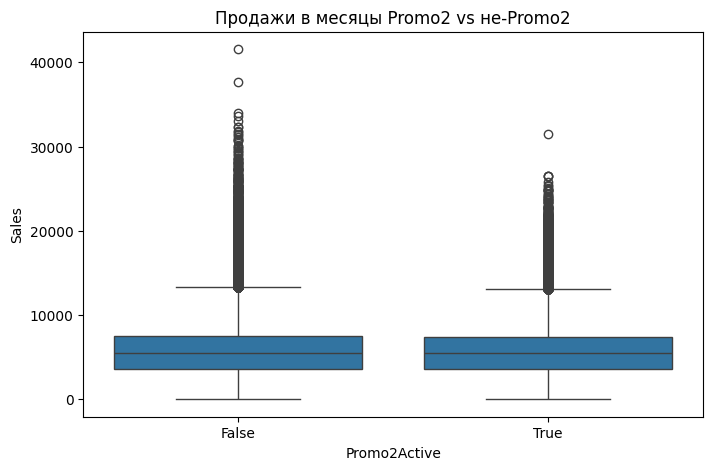

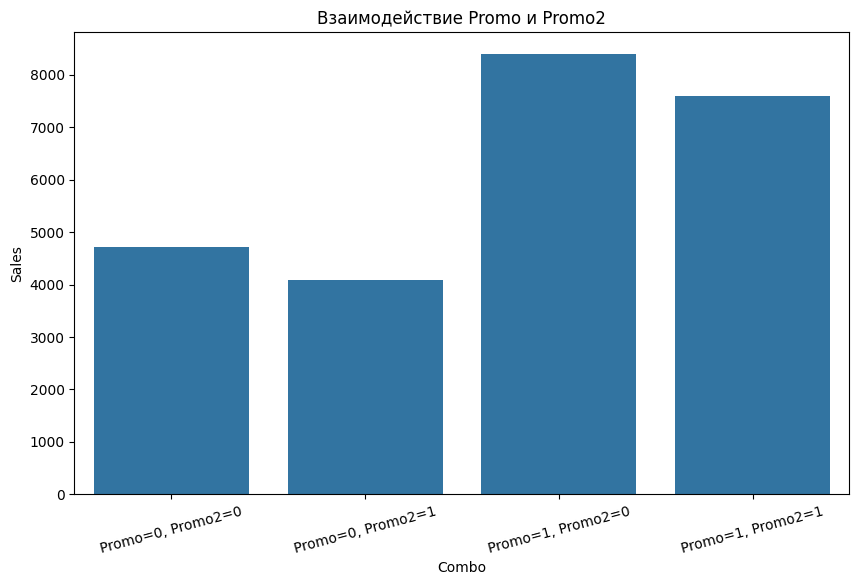

In [ ]:
# создаем фичу активности Promo2
month_map = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,
             'Jul':7,'Aug':8,'Sept':9,'Oct':10,'Nov':11,'Dec':12}

train_merged['Promo2Active'] = train_merged.apply(
    lambda x: (x['Promo2'] == 1 and 
               pd.notna(x['PromoInterval']) and
               x['Month'] in [month_map[m] for m in x['PromoInterval'].split(',')]),
    axis=1
)

plt.figure(figsize=(8, 5))
sns.boxplot(x='Promo2Active', y='Sales', data=train_merged[train_merged['Promo2']==1])
plt.title('Продажи в месяцы Promo2 vs не-Promo2')
plt.show()

# взаимодействие Promo и Promo2
plt.figure(figsize=(10, 6))
interaction = train_merged.groupby(['Promo', 'Promo2'])['Sales'].mean().reset_index()
interaction['Combo'] = interaction.apply(
    lambda x: f"Promo={int(x['Promo'])}, Promo2={int(x['Promo2'])}", axis=1
)
sns.barplot(x='Combo', y='Sales', data=interaction)
plt.title('Взаимодействие Promo и Promo2')
plt.xticks(rotation=15)
plt.show()

Promo2 коррелирует с низкими продажами \
Предположения:

    1. Не Promo2 снижает продажи, а низкие продажи становятся причиной подключения Promo2
    Promo2 подключают в слабых магазинах для поддержки продаж

    2. Постоянные акции обесцениваются
    Клиенты ждут скидок и не покупают по полной цене

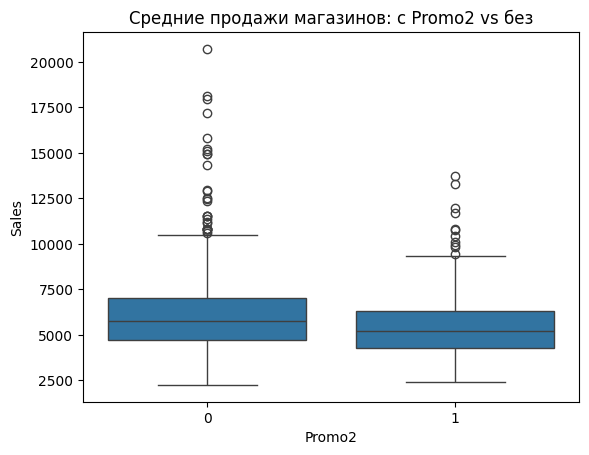

In [50]:
# Сравним характеристики магазинов с/без Promo2
store_stats = train_merged.groupby('Store').agg({
    'Sales': 'mean',
    'Promo2': 'first'
}).reset_index()

sns.boxplot(x='Promo2', y='Sales', data=store_stats)
plt.title('Средние продажи магазинов: с Promo2 vs без')
plt.show()

Проверили магазины с/без Promo2 на предмет продаж
Магазины с Promo2 изначально слабее

    Медиана продаж: Promo2=0 > Promo2=1
    Больше выбросов вверх у магазинов без Promo2
    Распределение у Promo2=1 смещено вниз

Вывод:
Promo2 - не причина, а следствие! Компания подключает долгосрочные акции к проблемным магазинам.

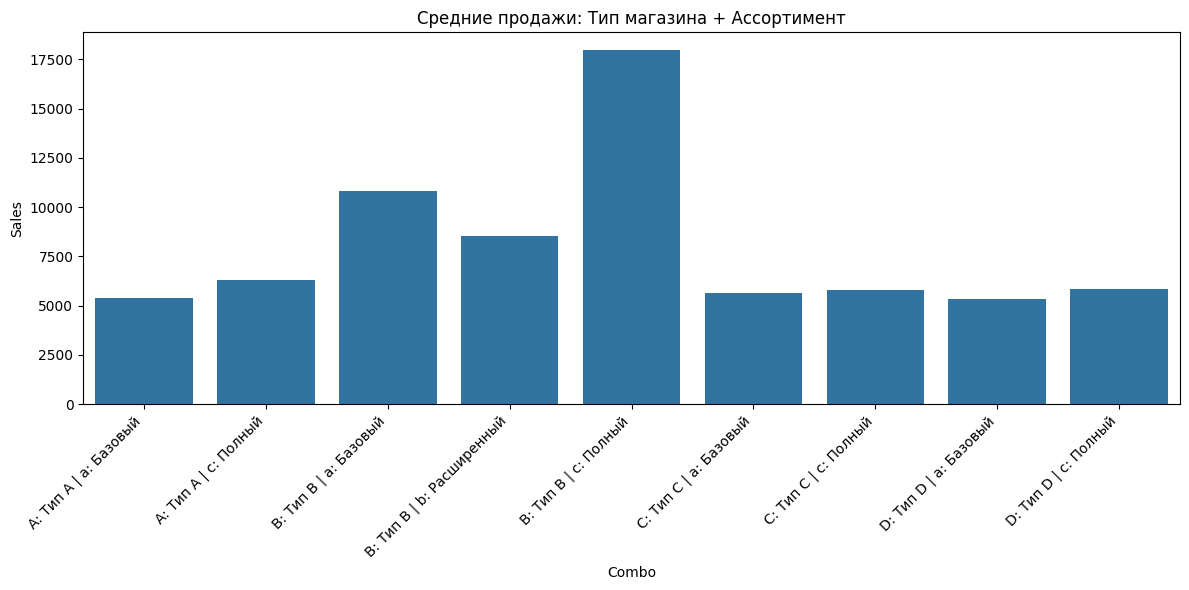

In [76]:
plt.figure(figsize=(12, 6))
combo_sales = train_merged.groupby(['StoreType', 'Assortment'])['Sales'].mean().reset_index()

store_names = {'a': 'A: Тип A', 'b': 'B: Тип B', 'c': 'C: Тип C', 'd': 'D: Тип D'}
assort_names = {'a': 'a: Базовый', 'b': 'b: Расширенный', 'c': 'c: Полный'}

combo_sales['Combo'] = (combo_sales['StoreType'].map(store_names) + ' | ' + 
                        combo_sales['Assortment'].map(assort_names))

sns.barplot(x='Combo', y='Sales', data=combo_sales)
plt.title('Средние продажи: Тип магазина + Ассортимент')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Анализ сезонности
Посмотрим, как продажи зависят от дня недели и месяца

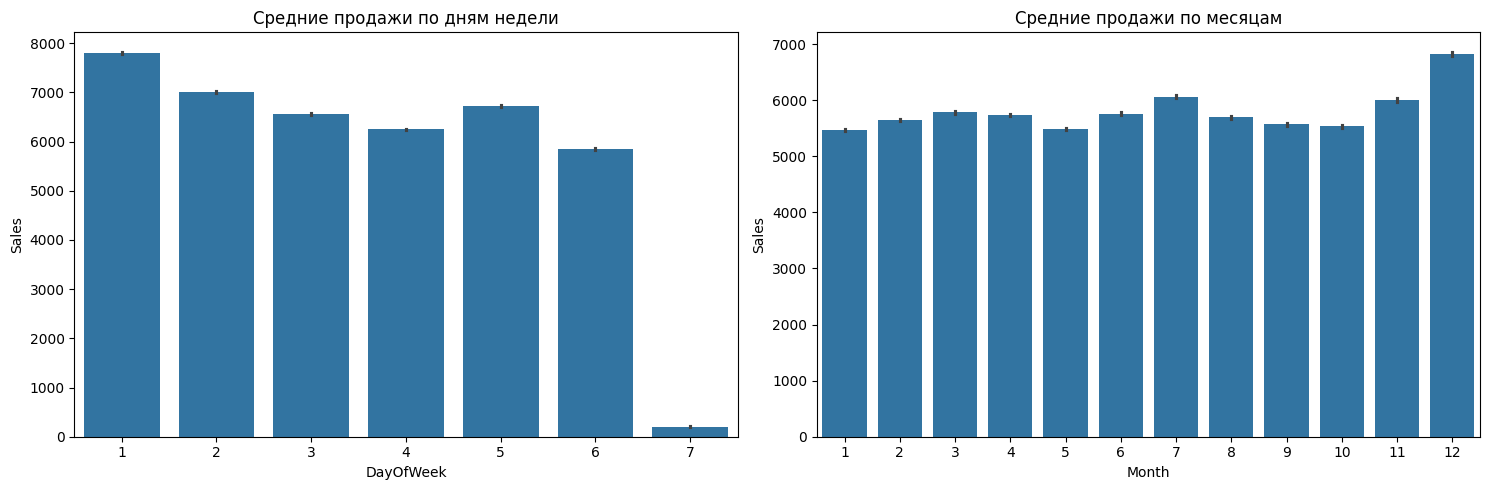

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Средние продажи по дням недели
sns.barplot(x='DayOfWeek', y='Sales', data=train_merged, ax=axes[0])
axes[0].set_title('Средние продажи по дням недели')

# Средние продажи по месяцам
sns.barplot(x='Month', y='Sales', data=train_merged, ax=axes[1])
axes[1].set_title('Средние продажи по месяцам')

plt.tight_layout()
plt.show()

Меньше всего покупают в воскресенье(так как большинство магазинов закрыты), а больше всего в понедельник и пятницу \
Топ месяцев: июль, ноябрь, декабрь \
Продажи явно сезонны по кварталам

#### Корреляционный анализ
Построим тепловую карту корреляций для числовых признаков.

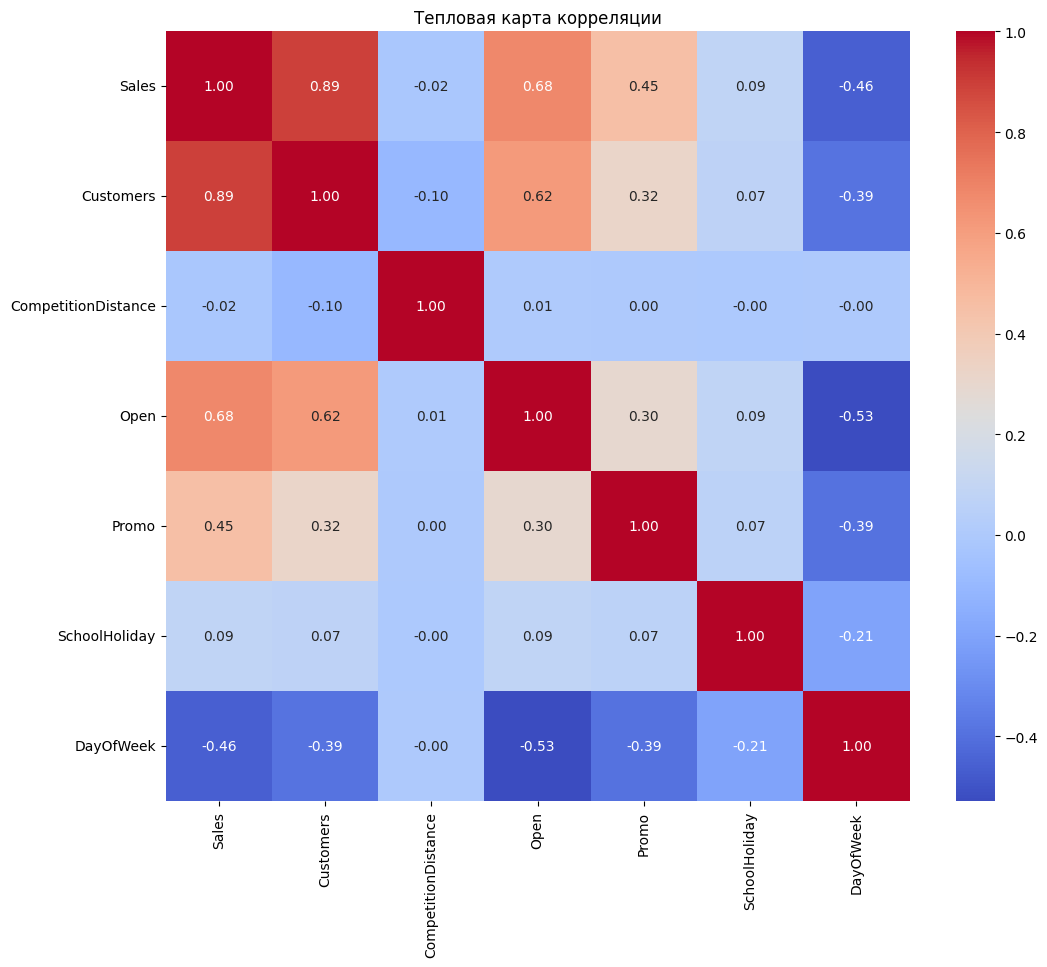

In [ ]:
plt.figure(figsize=(12, 10))
numeric_cols = ['Sales', 'Customers', 'CompetitionDistance', 'Open', 'Promo', 'SchoolHoliday', 'DayOfWeek', 'Month', 'Year']

numeric_cols = [c for c in numeric_cols if c in train_merged.columns]
corr = train_merged[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Тепловая карта корреляции')
plt.show()

Продажи сильно коррелируют с количеством покупателей \
Промо бустит продажи \
Отрицательная корреляция дня недели почти со всеми фичами объясняется очень низкими продажами в воскресенье(из-за того что магазы закрыты) 

#### Анализ конкуренции и клиентов
Изучим взаимосвязь продаж с количеством клиентов и расстоянием до конкурентов.

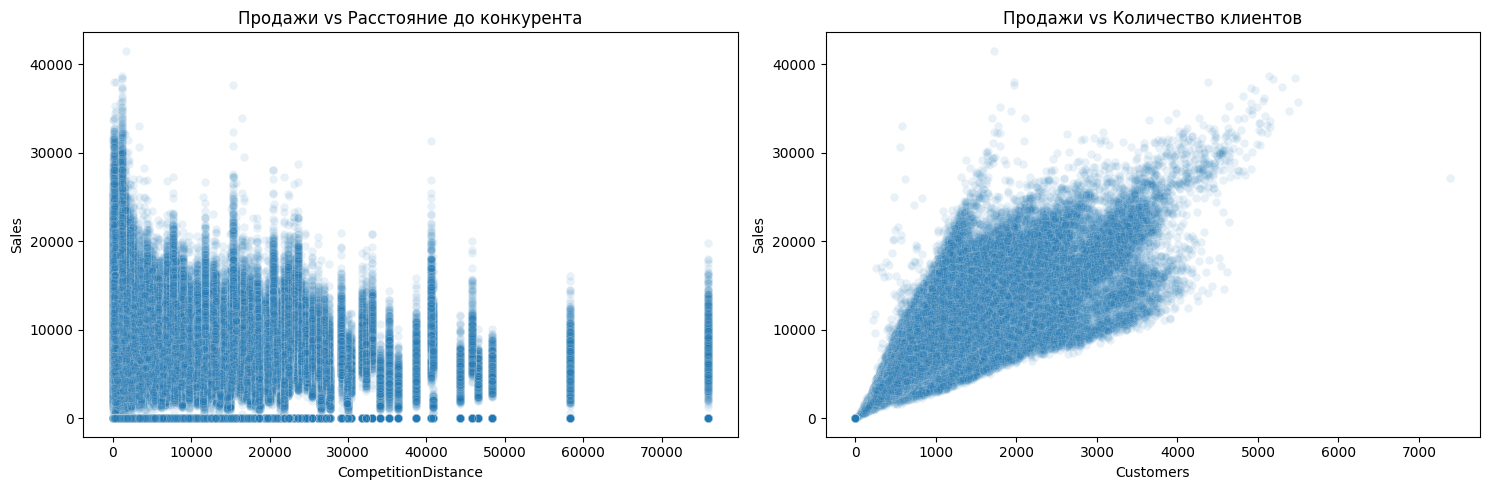

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# продажи vs расстояния до конкурента
sns.scatterplot(x='CompetitionDistance', y='Sales', data=train_merged, alpha=0.1, ax=axes[0])
axes[0].set_title('Продажи vs Расстояние до конкурента')

# продажи vs количества клиентов
sns.scatterplot(x='Customers', y='Sales', data=train_merged, alpha=0.1, ax=axes[1])
axes[1].set_title('Продажи vs Количество клиентов')

plt.tight_layout()
plt.show()

Customers главный драйвер продаж

Корреляция 0.89, на scatter почти линейная зависимость. Где больше трафика там больше выручка, все просто. Customers объясняет большую часть вариации в Sales.

День недели сильнейший фактор

Пик продаж в понедельник и вторник, провал в среду-четверг, пятница средняя, суббота падает, воскресенье почти ноль (магазины закрыты). Недельный паттерн жесткий и неравномерный - при сплите на валидацию резать надо по целым неделям, иначе распределение поедет.

Месяцы показывают сезонность

Декабрь огромный лидер (новогодний спрос), январь слабый, июль тоже сильный. Видна квартальная динамика.

Promo работает, Promo2 нет

Promo дает четкий рост median sales и customers, много выбросов вверх в дни акций. Promo2 почти не влияет - медианы одинаковые с нулем, иногда даже ниже. Promo это короткие всплески продаж, Promo2 долгосрочные акции для слабых магазинов где эффект размазан.

StoreType b встречается чаще всего

Тип b (крупные магазины) лидер по продажам и трафику. Лучшая комбинация StoreType b + Assortment c (полный ассортимент в большом магазине). Ассортимент c работает только в крупных точках, в маленьких разницы между a и c нет.

Open критичен

Закрытый магазин это почти всегда ноль продаж. Open сильно коррелирует с днем недели (воскресенья закрыты).

SchoolHoliday не влияет

Медианы одинаковые, корреляции нет, эффект нулевой или очень слабый.

CompetitionDistance не работает линейно

Корреляция близка к нулю, тренд не виден. Влияние конкуренции либо нелинейное либо зашумленное другими факторами.